<a href="https://colab.research.google.com/github/MargaritaGorbunova/Artificial_Intelligence_Methods_Coursework/blob/main/Lab_02_Air_Quality/air_quality_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Установка и импорт библиотек


In [5]:
!pip install torchmetrics -q

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils.class_weight import compute_class_weight

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchmetrics.classification import MulticlassAccuracy, MulticlassConfusionMatrix

Загрузка данных

In [6]:
# Загрузка данных из файла
from google.colab import files
import io

print("\nЗагрузите файл 'updated_pollution_dataset.csv'")
uploaded = files.upload()

# Чтение загруженного файла
for filename in uploaded.keys():
    print(f"Загружен файл: {filename}")
    data = pd.read_csv(io.BytesIO(uploaded[filename]))

print(f"\nРазмер датасета: {data.shape}")
print(f"Колонки: {list(data.columns)}")


Загрузите файл 'updated_pollution_dataset.csv'


Saving updated_pollution_dataset.csv to updated_pollution_dataset (1).csv
Загружен файл: updated_pollution_dataset (1).csv

Размер датасета: (5000, 10)
Колонки: ['Temperature', 'Humidity', 'PM2.5', 'PM10', 'NO2', 'SO2', 'CO', 'Proximity_to_Industrial_Areas', 'Population_Density', 'Air Quality']


Анализ и визуализация данных

Первые 5 строк данных:
   Temperature  Humidity  PM2.5  PM10   NO2   SO2    CO  \
0         29.8      59.1    5.2  17.9  18.9   9.2  1.72   
1         28.3      75.6    2.3  12.2  30.8   9.7  1.64   
2         23.1      74.7   26.7  33.8  24.4  12.6  1.63   
3         27.1      39.1    6.1   6.3  13.5   5.3  1.15   
4         26.5      70.7    6.9  16.0  21.9   5.6  1.01   

   Proximity_to_Industrial_Areas  Population_Density Air Quality  
0                            6.3                 319    Moderate  
1                            6.0                 611    Moderate  
2                            5.2                 619    Moderate  
3                           11.1                 551        Good  
4                           12.7                 303        Good  

Информация о данных:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 10 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                    

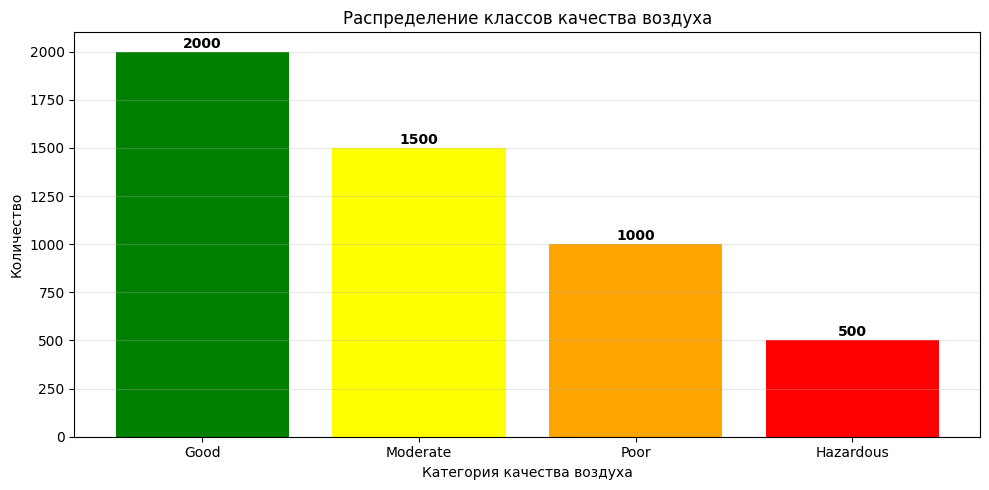

In [7]:
print("Первые 5 строк данных:")
print(data.head())

print("\nИнформация о данных:")
print(data.info())

print("\nРаспределение качества воздуха:")
print(data['Air Quality'].value_counts())

# Визуализация распределения классов
plt.figure(figsize=(10, 5))
class_counts = data['Air Quality'].value_counts()
colors = ['green', 'yellow', 'orange', 'red']
bars = plt.bar(class_counts.index, class_counts.values, color=colors)
plt.title('Распределение классов качества воздуха')
plt.xlabel('Категория качества воздуха')
plt.ylabel('Количество')
plt.grid(True, alpha=0.3, axis='y')

for bar, count in zip(bars, class_counts.values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5,
             str(count), ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

Предобработка данных

In [8]:
# Кодирование меток
map_dict = {'Good': 0, 'Moderate': 1, 'Poor': 2, 'Hazardous': 3}
data["Air Quality"] = data["Air Quality"].map(map_dict)

print("Кодирование меток:")
for label, code in map_dict.items():
    print(f"{label}: {code}")

# Нормализация признаков
scaler = MinMaxScaler()
x_scaled = scaler.fit_transform(data.drop(columns=['Air Quality']))
x = pd.DataFrame(x_scaled, columns=data.drop(columns=['Air Quality']).columns)

y = data['Air Quality']

# Разделение на обучающую и тестовую выборки
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

y_train = y_train.astype(int)
y_test = y_test.astype(int)

print(f"\nОбучающая выборка: {x_train.shape[0]} образцов")
print(f"Тестовая выборка: {x_test.shape[0]} образцов")
print(f"Количество признаков: {x_train.shape[1]}")
print(f"Количество классов: {len(y_train.unique())}")

Кодирование меток:
Good: 0
Moderate: 1
Poor: 2
Hazardous: 3

Обучающая выборка: 4000 образцов
Тестовая выборка: 1000 образцов
Количество признаков: 9
Количество классов: 4


Балансировка классов

In [9]:
# Расчет весов классов
class_weights = compute_class_weight(class_weight='balanced',
                                     classes=np.array([0, 1, 2, 3]),
                                     y=y_train.to_numpy())

print("Веса классов для компенсации дисбаланса:")
for class_id, weight in enumerate(class_weights):
    class_name = list(map_dict.keys())[list(map_dict.values()).index(class_id)]
    print(f"{class_name}: {weight:.3f}")

class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32).to(device)

Веса классов для компенсации дисбаланса:
Good: 0.629
Moderate: 0.829
Poor: 1.229
Hazardous: 2.571


Создание PyTorch Dataset и DataLoader

In [10]:
class AirQualityDataset(Dataset):
    def __init__(self, x, y):
        self.x = torch.tensor(x.values, dtype=torch.float32)
        self.y = torch.tensor(y.values, dtype=torch.long)

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

train_dataset = AirQualityDataset(x_train, y_train)
test_dataset = AirQualityDataset(x_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=132, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=132, shuffle=False)

print(f"Размер батча: 132")
print(f"Количество батчей в обучении: {len(train_loader)}")
print(f"Количество батчей в тесте: {len(test_loader)}")


Размер батча: 132
Количество батчей в обучении: 31
Количество батчей в тесте: 8


Определение архитектуры нейронной сети

In [11]:
class NeuralNet(nn.Module):
    def __init__(self, input_size, num_classes):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, num_classes)
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

input_size = x_train.shape[1]
num_classes = len(y_train.unique())

model = NeuralNet(input_size, num_classes).to(device)

print("Архитектура модели:")
print(model)
print(f"\nВходной размер: {input_size}")
print(f"Количество классов: {num_classes}")
print(f"Всего параметров: {sum(p.numel() for p in model.parameters()):,}")

Архитектура модели:
NeuralNet(
  (fc1): Linear(in_features=9, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (fc4): Linear(in_features=32, out_features=4, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)

Входной размер: 9
Количество классов: 4
Всего параметров: 11,748


Настройка функции потерь и оптимизатора

In [12]:
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)
optimizer = optim.Adam(model.parameters(), lr=0.001)
accuracy_metric = MulticlassAccuracy(num_classes=num_classes).to(device)

print("Функция потерь: CrossEntropyLoss с весами классов")
print("Оптимизатор: Adam с learning rate = 0.001")

Функция потерь: CrossEntropyLoss с весами классов
Оптимизатор: Adam с learning rate = 0.001


Обучение модели

In [13]:
num_epochs = 50
train_losses = []
test_losses = []

print("Начало обучения...")
print("="*70)

for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    train_losses.append(avg_loss)

    model.eval()
    test_loss = 0
    y_true, y_pred = [], []

    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            test_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            y_true.extend(y_batch.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    avg_test_loss = test_loss / len(test_loader)
    test_losses.append(avg_test_loss)

    accuracy = accuracy_metric(torch.tensor(y_pred, device=device), torch.tensor(y_true, device=device))

    if (epoch + 1) % 5 == 0 or epoch == 0:
        print(f"Эпоха {epoch+1}/{num_epochs} | Потери на обучении: {avg_loss:.4f} | Потери на тесте: {avg_test_loss:.4f} | Точность: {accuracy:.4f}")

print("="*70)
print("Обучение завершено")

Начало обучения...
Эпоха 1/50 | Потери на обучении: 1.3536 | Потери на тесте: 1.2420 | Точность: 0.4707
Эпоха 5/50 | Потери на обучении: 0.3534 | Потери на тесте: 0.2771 | Точность: 0.8694
Эпоха 10/50 | Потери на обучении: 0.3115 | Потери на тесте: 0.2348 | Точность: 0.9141
Эпоха 15/50 | Потери на обучении: 0.2822 | Потери на тесте: 0.2212 | Точность: 0.9137
Эпоха 20/50 | Потери на обучении: 0.2807 | Потери на тесте: 0.2202 | Точность: 0.9056
Эпоха 25/50 | Потери на обучении: 0.2533 | Потери на тесте: 0.2202 | Точность: 0.9116
Эпоха 30/50 | Потери на обучении: 0.2520 | Потери на тесте: 0.2113 | Точность: 0.9147
Эпоха 35/50 | Потери на обучении: 0.2489 | Потери на тесте: 0.2002 | Точность: 0.9186
Эпоха 40/50 | Потери на обучении: 0.2349 | Потери на тесте: 0.2044 | Точность: 0.9139
Эпоха 45/50 | Потери на обучении: 0.2277 | Потери на тесте: 0.1984 | Точность: 0.9151
Эпоха 50/50 | Потери на обучении: 0.2237 | Потери на тесте: 0.1967 | Точность: 0.9214
Обучение завершено


Визуализация процесса обучения


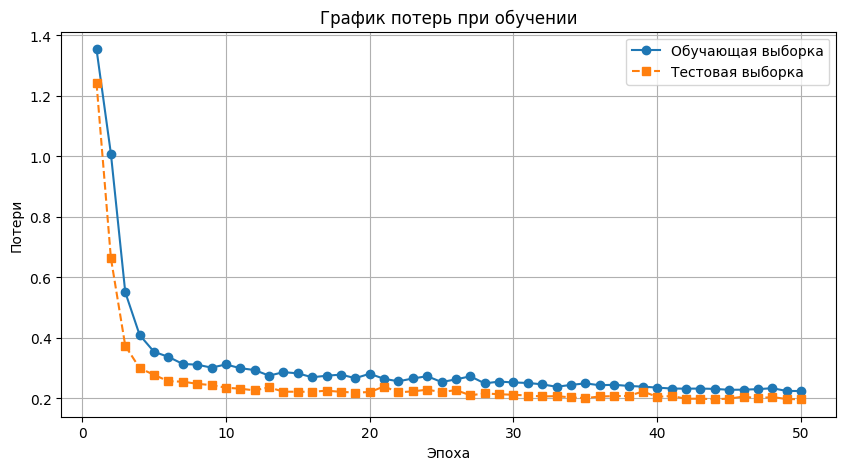

Финальные потери на обучении: 0.2237
Финальные потери на тесте: 0.1967
Финальная точность: 0.9214


In [14]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_losses, label="Обучающая выборка", marker="o")
plt.plot(range(1, num_epochs + 1), test_losses, label="Тестовая выборка", linestyle="dashed", marker="s")
plt.xlabel("Эпоха")
plt.ylabel("Потери")
plt.title("График потерь при обучении")
plt.legend()
plt.grid()
plt.show()

print(f"Финальные потери на обучении: {train_losses[-1]:.4f}")
print(f"Финальные потери на тесте: {test_losses[-1]:.4f}")
print(f"Финальная точность: {accuracy:.4f}")

Матрица ошибок

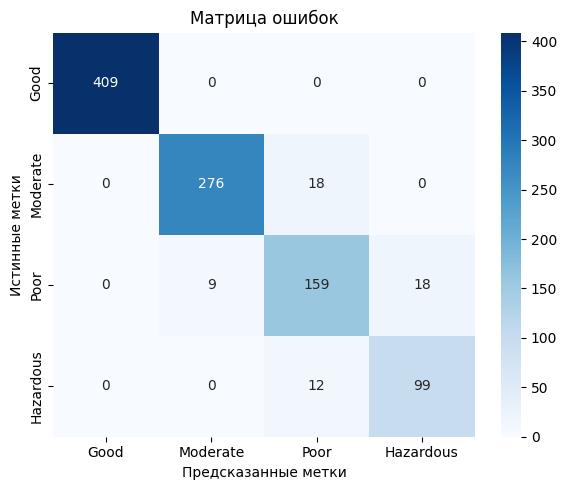

In [15]:
conf_matrix = MulticlassConfusionMatrix(num_classes=num_classes).to(device)
conf_matrix_result = conf_matrix(torch.tensor(y_pred, device=device), torch.tensor(y_true, device=device)).cpu().numpy()

plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix_result, annot=True, fmt="d", cmap="Blues",
            xticklabels=map_dict.keys(), yticklabels=map_dict.keys())
plt.xlabel("Предсказанные метки")
plt.ylabel("Истинные метки")
plt.title("Матрица ошибок")
plt.tight_layout()
plt.show()

Сохранение модели


In [16]:
torch.save(model.state_dict(), "air_quality_model.pth")
print("Модель сохранена как 'air_quality_model.pth'")

# Проверка загрузки модели
model.load_state_dict(torch.load("air_quality_model.pth"))
model.eval()
print("Модель успешно загружена")


Модель сохранена как 'air_quality_model.pth'
Модель успешно загружена


Итоговый отчет

In [17]:
print("="*70)
print("ИТОГОВЫЙ ОТЧЕТ")
print("="*70)
print(f"Датасет: классификация качества воздуха")
print(f"Количество классов: 4")
print(f"Обучающих образцов: {x_train.shape[0]}")
print(f"Тестовых образцов: {x_test.shape[0]}")
print(f"Финальная точность на тесте: {accuracy:.4f}")
print(f"Финальные потери на тесте: {test_losses[-1]:.4f}")
print(f"Количество эпох обучения: {num_epochs}")
print(f"Использованное устройство: {device}")
print("="*70)

ИТОГОВЫЙ ОТЧЕТ
Датасет: классификация качества воздуха
Количество классов: 4
Обучающих образцов: 4000
Тестовых образцов: 1000
Финальная точность на тесте: 0.9214
Финальные потери на тесте: 0.1967
Количество эпох обучения: 50
Использованное устройство: cuda
